# Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook as tqdm
import os
from pathlib import Path

from bs4 import BeautifulSoup
from prettytable import PrettyTable

# [1]. Reading Data

In [2]:
path = Path('data')
list(iter(path.iterdir()))

[PosixPath('data/database.sqlite'),
 PosixPath('data/GoogleNews-vectors-negative300.bin.gz'),
 PosixPath('data/hashes.txt'),
 PosixPath('data/Reviews.csv')]

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect(path/'database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
df = pd.read_sql_query(""" SELECT * FROM Reviews """, con)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Exploratory analysis

In [4]:
df.shape

(568454, 10)

In [5]:
sns.set_style('whitegrid')

In [6]:
def sentiment_score(x):
    if x > 3:
        return 'positive'
    elif x < 3:
        return 'negetive'
    else:
        return 'neutral'

df['Sentiment'] = df.Score.map(sentiment_score)
print("Number of data points in our data", df.shape)
df.head()

Number of data points in our data (568454, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negetive
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negetive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


## Helpfulness

In [7]:
def helfulness_score(x):
    score = ''
    if x > 0.75:
        score = '>75%'
    elif x <= 0.75 and x >= 0.25:
        score = '25-75%'
    elif x < 0.25:
        score = '<25%'
    else:
        score = 'invalid'
    return score

df['helfulness'] = ((df.HelpfulnessNumerator / df.HelpfulnessDenominator)
                            .apply(helfulness_score))


df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,helfulness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive,>75%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negetive,invalid
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive,>75%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negetive,>75%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive,invalid


In [8]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

# changing reviews with score less than 3 to be negetive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
# Deduplication of entries
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
# Checking to see how much of data still remains
(final['Id'].size * 1.0) / (filtered_data['Id'].size*1.0) * 100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [14]:
final = final.sort_values(['Time'], axis=0)
final = final.head(100000)

In [15]:
final.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
409001,442350,B000R5IOMO,A2A1XYSB692L6J,"Patricia ""A Reader""",4,4,1,1233532800,S O O O O O......G O O D...! ! ! ! !,"When I was little, I coined a word for things ..."
63126,68584,B000E63LOM,A32RWGJEWFUAB,SAJL,15,15,1,1162684800,Start your morning with a roar,"Move over coffee, I'll take some Morning Thund..."
476880,515702,B001E52WS8,A390Z489ECG711,Gary Barnes,0,0,1,1198713600,My bedtime coffee,Perfect for relaxing me after a long stressful...
351134,379838,B002DD2HQW,ASVK8EB8CML4X,"Lindsay Nixon ""happyherbivore""",4,8,0,1274054400,WAY TOO SPICY,It's all cayenne and not authentic bebere. way...
137014,148715,B001OCBT3U,AKJHHD5VEH7VG,Dominique W,0,0,1,1248307200,Payday candybar/granola bar hybrid,I am a HUGE fan of Payday candybars. I also l...


In [16]:
final.shape

(100000, 10)

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
    

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
stemmer = SnowballStemmer('english')

In [20]:
le=WordNetLemmatizer()

In [21]:
# Combining all the above
preprocessed_reviews = []
preprocessed_reviews_stem = []
preprocessed_reviews_lema = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence= sentence.split()
    sentence_norm = ' '.join(e.lower() for e in sentence if e.lower() not in stopwords)
    sentence_stem = ' '.join(stemmer.stem(e.lower()) for e in sentence if e.lower() not in stopwords)
    sentence_lema = ' '.join(le.lemmatize(e.lower()) for e in sentence if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence_norm.strip())
    preprocessed_reviews_stem.append(sentence_stem.strip())
    preprocessed_reviews_lema.append(sentence_lema.strip())
    

In [22]:
preprocessed_reviews[1500]

'best hot chocolate first tried california hoped one day could find local market excited find amazon get shipped gifts husband'

In [23]:
preprocessed_reviews_stem[1500]

'best hot chocol first tri california hope one day could find local market excit find amazon get ship gift husband'

In [24]:
preprocessed_reviews_lema[1500]

'best hot chocolate first tried california hoped one day could find local market excited find amazon get shipped gift husband'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [25]:
preprocessed_summary = []
preprocessed_summary_stem = []
preprocessed_summary_lema = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence= sentence.split()
    sentence_norm = ' '.join(e.lower() for e in sentence if e.lower() not in stopwords)
    sentence_stem = ' '.join(stemmer.stem(e.lower()) for e in sentence if e.lower() not in stopwords)
    sentence_lema = ' '.join(le.lemmatize(e.lower()) for e in sentence if e.lower() not in stopwords)
    preprocessed_summary.append(sentence_norm.strip())
    preprocessed_summary_stem.append(sentence_stem.strip())
    preprocessed_summary_lema.append(sentence_lema.strip())
    

In [26]:
preprocessed_summary[20000]

'excellent lemon flavor'

In [27]:
preprocessed_summary_stem[20000]

'excel lemon flavor'

In [28]:
preprocessed_summary_lema[20000]

'excellent lemon flavor'

In [29]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [30]:
len(preprocessed_reviews_lema)

100000

In [32]:
X_train = preprocessed_reviews_lema[:60000]
X_cv = preprocessed_reviews_lema[60000:80000]
X_test = preprocessed_reviews_lema[80000:]
y_train = final.Score[:60000]
y_cv = final.Score[60000:80000]
y_test = final.Score[80000:]
np.array(X_train).shape, np.array(X_cv).shape, np.array(X_test).shape, y_train.shape, y_cv.shape, y_test.shape



((60000,), (20000,), (20000,), (60000,), (20000,), (20000,))

### BAG OF WORDS

In [52]:
count_vect_bow = CountVectorizer(max_features = 5000)
X_train_bow = count_vect_bow.fit_transform(X_train)
X_cv_bow = count_vect_bow.transform(X_cv)
X_test_bow = count_vect_bow.transform(X_test)
X_train_bow.shape, X_test_bow.shape

((60000, 5000), (20000, 5000))

### Bi-Grams and n-Grams.

In [53]:
count_vect_bigram = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
X_train_bigram = count_vect_bigram.fit_transform(X_train)
X_cv_bigram = count_vect_bigram.transform(X_cv)
X_test_bigram = count_vect_bigram.transform(X_test)
print(X_train_bigram.shape, X_test_bigram.shape)
print("the number of unique words including both unigrams and bigrams ", X_train_bigram.get_shape()[1])



(60000, 5000) (20000, 5000)
the number of unique words including both unigrams and bigrams  5000


### TF-IDF

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train_tfidf = count_vect.fit(X_train)
print("some sample features(unique words in the corpus)",X_train_tfidf.get_feature_names()[0:10])
X_train_tfidf = count_vect.transform(X_train)
X_cv_tfidf = count_vect.transform(X_cv)
X_test_tfidf = count_vect.transform(X_test)

print(X_train_tfidf.shape, X_test_tfidf.shape)
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape())

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able order', 'absolute', 'absolute favorite', 'absolutely']
(60000, 5000) (20000, 5000)
the number of unique words including both unigrams and bigrams  (60000, 5000)


### Word2Vec

In [37]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews_lema:
    list_of_sentance.append(sentance.split())

In [38]:
vec_path = Path('model')
list(iter(vec_path.iterdir()))

[PosixPath('model/GoogleNews-vectors-negative300.bin')]

In [39]:
is_your_ram_gt_16g=True
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile(vec_path/'GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format(vec_path/'GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8498004674911499), ('terrific', 0.8460293412208557), ('good', 0.8423929214477539), ('excellent', 0.8244956731796265), ('wonderful', 0.8121395111083984), ('awesome', 0.8074479103088379), ('nice', 0.7649987936019897), ('perfect', 0.7531788349151611), ('amazing', 0.6831420660018921), ('incredible', 0.6820898056030273)]
[('greatest', 0.7759233713150024), ('best', 0.738574743270874), ('nastiest', 0.702406644821167), ('tastiest', 0.6345801949501038), ('disgusting', 0.6144161224365234), ('smoothest', 0.6054435968399048), ('awful', 0.5969213247299194), ('horrible', 0.5911906957626343), ('terrible', 0.5887694954872131), ('nicest', 0.573161244392395)]


In [40]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16602
sample words  ['witty', 'little', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whale', 'india', 'rose', 'love', 'new', 'word', 'introduces', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'song', 'student', 'teaching', 'preschooler', 'turned', 'whole', 'school']


## TODO: Avg W2V and TDIDF - W2V Logic

### Avg W2V

In [41]:
sent_vectors = []
for sent in tqdm(list_of_sentance):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

30000
50


### TDIDF - W2V

In [42]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))



tfidf_feat = model.get_feature_names()
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [47]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
GridSearchCV

## SVM

In [41]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, \
                            roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import math

In [42]:
X_train_bow.shape, y_train.shape

((60000, 5000), (60000,))

In [ ]:
X_train_bow

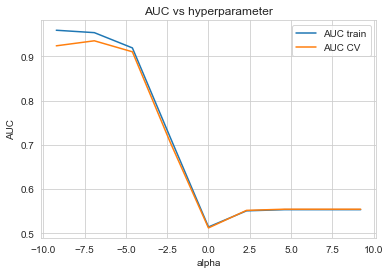

optimal alpha for which auc is maximum :  0.001


In [43]:
alpha = np.array([10**-4, 10**-3,10**-2,10**-1,1,10,10**2,10**3,10**4])
auc_train = []
auc_cv = []
for a in alpha:
    model = SGDClassifier(alpha=a)
    clf = CalibratedClassifierCV(model, cv=3)
    clf.fit(X_train_bow, y_train)
    prob = clf.predict_proba(X_cv_bow)[:,1]
    auc_cv.append(roc_auc_score(y_cv, prob))
    probtr=clf.predict_proba(X_train_bow)[:,1]
    auc_train.append(roc_auc_score(y_train,probtr))
optimal_alpha= alpha[np.argmax(auc_cv)] 
alpha=[math.log(x) for x in alpha]#converting values of alpha into logarithm
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(alpha, auc_train, label='AUC train')
ax.plot(alpha, auc_cv, label='AUC CV')
plt.title('AUC vs hyperparameter')
plt.xlabel('alpha')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal alpha for which auc is maximum : ',optimal_alpha)

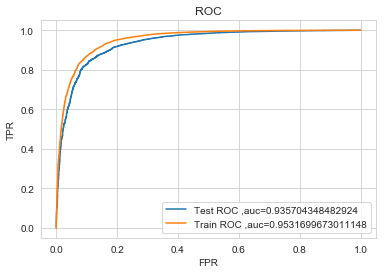

In [45]:
#training our model for alpha=0.001
#ROC curve
model=SGDClassifier(alpha=0.001)
clf=CalibratedClassifierCV(model, cv=3)
clf.fit(X_train_bow,y_train)
predi=clf.predict_proba(X_test_bow)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=svm.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


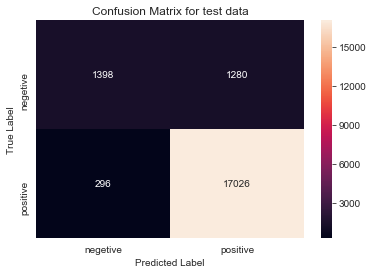

In [50]:
pred = clf.predict(X_test_bow)
conf = confusion_matrix(y_test, pred)
label = ['negetive', 'positive']
df = pd.DataFrame(conf, index=label, columns=label)
sns.heatmap(df, annot=True, fmt='d')
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [54]:
all_features = count_vect.get_feature_names()
model=SGDClassifier(alpha=0.001)
model.fit(X_train_bo,y_train)
weight=model.coef_
pos_indx=np.argsort(weight)[:,::-1]

neg_indx=np.argsort(weight)

print('Top 10 positive features :')
for i in list(pos_indx[0][0:10]):
    print(all_features[i])

['ability',
 'able',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'acai',
 'accept',
 'acceptable',
 'access',
 'accident',
 'accidentally',
 'accompaniment',
 'according',
 'accordingly',
 'account',
 'accurate',
 'accustomed',
 'acerola',
 'ache',
 'achieve',
 'acid',
 'acidic',
 'acidity',
 'acquired',
 'across',
 'act',
 'acting',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'ad',
 'adagio',
 'adam',
 'add',
 'added',
 'addict',
 'addicted',
 'addicting',
 'addiction',
 'addictive',
 'adding',
 'addition',
 'additional',
 'additionally',
 'additive',
 'address',
 'adequate',
 'adjust',
 'admit',
 'adopted',
 'adorable',
 'adore',
 'adores',
 'adult',
 'advance',
 'advantage',
 'adventure',
 'adventurous',
 'advertise',
 'advertised',
 'advertising',
 'advice',
 'advise',
 'advised',
 'aerogarden',
 'aerogrow',
 'affect',
 'affected',
 'affiliated',
 'afford',
 'affordable',
 'afraid',
 'africa',
 'african',
 'afternoon',
 'aftertaste',
 'afterward',
 'afterwa